In [2]:
import keras
import numpy as np
import os
import PIL
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import helpers
from pylab import imread, imshow
from skimage.color import rgb2gray
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, core , UpSampling2D
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from importlib import reload
helpers = reload(helpers)

In [3]:
def get_opt():
    #All parameters are defualt mentioned in paper
    return Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)



In [4]:
def encoder_conv_block_batch_norm(inputs, n_filters, dropout, kernel_size=3, batchNorm = True):
    net = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(inputs)
    if batchNorm:
        net = BatchNormalization()(net)
    net = Activation("relu")(net)
        # second layer
    net = Dropout(dropout)(net)
    net = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal", padding="same")(net)
    if batchNorm:
        net = BatchNormalization()(net)
    net = Activation("relu")(net)
    return net

In [5]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        # second layer
        x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
        padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    return x

In [6]:
def get_unet_3(dropout, input_img):
    inputs = input_img
    patch_size = 32
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_last')(inputs)
    conv1 = Dropout(dropout)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    #
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_last')(pool1)
    conv2 = Dropout(dropout)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    #
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_last')(pool2)
    conv3 = Dropout(dropout)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv3)

    up1 = UpSampling2D(size=(2, 2))(conv3)
    up1 = concatenate([conv2,up1])
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_last')(up1)
    conv4 = Dropout(dropout)(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv4)
    #
    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = concatenate([conv1,up2])
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_last')(up2)
    conv5 = Dropout(dropout)(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv5)
    #
    conv6 = Conv2D(2, (1, 1), activation='relu',padding='same',data_format='channels_last')(conv5)
    conv6 = core.Reshape((2,32*32))(conv6)
    conv6 = core.Permute((2,1))(conv6)
    ############
    conv7 = core.Activation('softmax')(conv6)

    model = Model(inputs=inputs, outputs=conv7)
    opt  = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer = opt, loss = 'binary_crossentropy')
    return model

In [7]:
def unet_gen(dropout, input_img, transposedConv, n_filters = 32):
    inputs = input_img
    patch_size = 32
    block1 = encoder_conv_block_batch_norm(inputs, n_filters =n_filters,
                                  kernel_size=3, dropout = dropout*0.5)
    pool1 = MaxPooling2D((2, 2))(block1)
    #conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_last')(inputs)
    #conv1 = Dropout(dropout)(conv1)
    #conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv1)
    #pool1 = MaxPooling2D((2, 2))(conv1)
    #
    block2 = encoder_conv_block_batch_norm(pool1, n_filters = n_filters*2,
                                  kernel_size=3, dropout = dropout)
    pool2 = MaxPooling2D((2, 2))(block2) 
    #conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_last')(pool1)
    #conv2 = Dropout(dropout)(conv2)
    #conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv2)
    #pool2 = MaxPooling2D((2, 2))(conv2)
    #
    bridge = encoder_conv_block_batch_norm(pool2, n_filters = n_filters*4,
                                  kernel_size=3, dropout = dropout)
    
    #conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_last')(pool2)
    #conv3 = Dropout(dropout)(conv3)
    #conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv3)
    up1 = bridge
    if transposedConv:
        up1 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (up1)
    else:
        up1 = UpSampling2D(size=(2, 2))(up1)
    up1 = concatenate([block2,up1])
    up_block2 = encoder_conv_block_batch_norm(up1, n_filters = n_filters*2,
                                  kernel_size=3, dropout= dropout)
    
    #conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_last')(up1)
    #conv4 = Dropout(dropout)(conv4)
    #conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv4)
    #
    up2 = up_block2
    if transposedConv:
        up2 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (up2)
    else:
        up2 = UpSampling2D(size=(2, 2))(up2)
    up2 = concatenate([block1,up2])
    up_block1 = encoder_conv_block_batch_norm(up2, n_filters = n_filters,
                                  kernel_size=3, dropout = dropout)
    #conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_last')(up2)
    #conv5 = Dropout(dropout)(conv5)
    #conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv5)
    #
    outputs = Conv2D(1, (1, 1), activation='sigmoid',padding='same')(up_block1)
    #conv6 = core.Reshape((2,32*32))(conv6)
    #conv6 = core.Permute((2,1))(conv6)
    ############
    #conv7 = core.Activation('softmax')(conv6)
    opt = get_opt()
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer = opt, loss = 'binary_crossentropy')
    return model

In [8]:
def get_transp_conv_unet(dropout, input_img):
    return unet_gen(dropout = dropout, input_img = input_img, transposedConv = True)

In [9]:
def get_up_sample_unet(dropout, input_img):
    return unet_gen(dropout = dropout, input_img = input_img, transposedConv = False)

In [10]:
def get_unet_seismic(input_img, dropout, n_filters=16, batchnorm=True):
    # contracting path
    print("SEISMIC UNET")
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout)(p1)
    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)
    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)
    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    opt  = get_opt()
    model.compile(optimizer = opt, loss = 'binary_crossentropy')
    return model

In [11]:
def load_images_from_folder(folder_path):
    file_names = os.listdir(folder_path)
    file_names.sort()
    images = []
    for filename in file_names:
        try:
            image =imread(folder_path + filename)
            images.append(rgb2gray(image).reshape(32,32,1))
        except:
            continue
    return images

In [12]:
def generator(x_train, y_train, batch_size):
    data_gen = ImageDataGenerator(
        horizontal_flip = True, vertical_flip = True,
    ).flow(x_train, x_train, batch_size, seed=1)
    mask_gen = ImageDataGenerator(
        horizontal_flip = True, vertical_flip = True
    ).flow(y_train, y_train, batch_size, seed=1)
    while True:
        x_batch, _ = data_gen.next()
        y_batch, _ = mask_gen.next()
        yield x_batch, y_batch

## Test data augmentation function

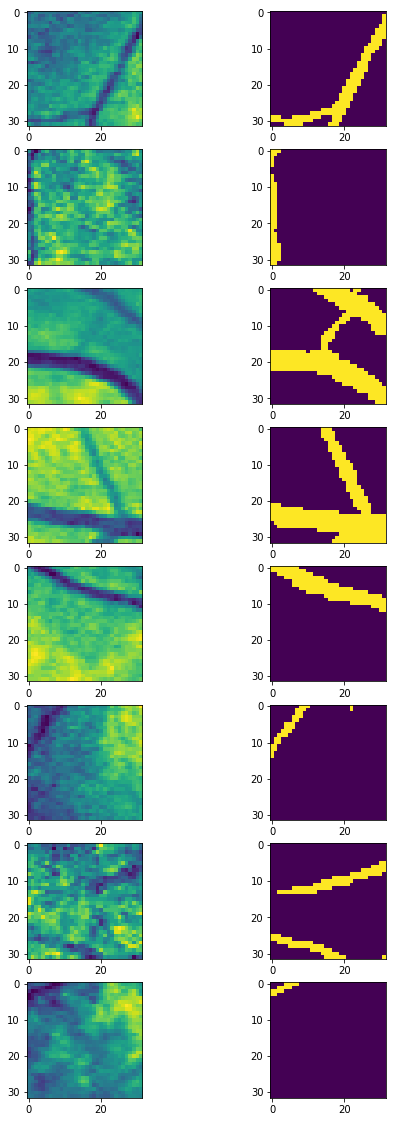

In [13]:

X_train = np.array(load_images_from_folder("../../data/DRIVE/training/patches/"))
y_train = np.array(load_images_from_folder("../../data/DRIVE/training/patchLabels/"))
image_batch, mask_batch = next(generator(X_train, y_train, 8))
fix, ax = plt.subplots(8,2, figsize=(8,20))
for i in range(8):
    ax[i,0].imshow(image_batch[i,:,:,0])
    ax[i,1].imshow(mask_batch[i,:,:,0])
plt.show()

In [14]:
def train(epochs, n_folds, model_dict, saveModel = False):
    X = np.array(load_images_from_folder("../../data/DRIVE/training/patches/"))
    y = np.array(load_images_from_folder("../../data/DRIVE/training/patchLabels/"))
    load_model = model_dict['load_model']
    args = model_dict['args']
    model = load_model(**args)
    batch_size = 32
    historyList =[]
    pathToSaveModel = "../../savedModels/"
    if saveModel:
        #if we cant save then we crash here
        model.save(pathToSaveModel + "test.h5")
    if n_folds > 0:
        if (len(X) % n_folds) != 0:
            raise Exception('Same eye in validation and traning set, Patches: ', X_train.shape[1], ' Folds', n_folds)
        sizeFold = len(X) // n_folds
        fold_idx = []
        for fold in range(n_folds):
            for curIdx in range(sizeFold):
                fold_idx.append(fold)
        fold_idx = np.array(fold_idx)
    
        for fold in range(n_folds):
            train_idx = fold_idx != fold
            test_idx = fold_idx == fold
            X_train = X[train_idx]
            y_train = y[train_idx]
            X_test = X[test_idx]
            y_test = y[test_idx]
            model = load_model(**args)
            history = model.fit_generator(generator(X_train, y_train, batch_size = batch_size),
                                  epochs = epochs, steps_per_epoch = len(X_train)//batch_size,
                                         validation_data = (X_test,y_test))
            historyList.append(history)
    elif saveModel or (n_folds == 0):
        model = load_model(**args)
        history = model.fit_generator(generator(X, y, batch_size = batch_size),
                                      epochs = epochs, steps_per_epoch = len(X)//batch_size)
        historyList.append(history)
        if saveModel:
            model.save(pathToSaveModel+model_dict['name']+".h5")
    return model, historyList
    

## Train model on the full data set, no cross validation

In [15]:
#args1 = {'input_img' : Input((32,32,1)), 'dropout' : 0.05}
#model_dict = {'load_model' : get_transp_conv_unet, 'args' : args1}
#res, historyList = train(epochs = 40, n_folds = 2, model_dict = model_dict)


## Compare 3 models with different dropout

In [29]:
def train_3_models_dropout():
    epochs = 1
    model_name = ["TranspConv", "Seismic", "UpSample"]

    load_model = [get_transp_conv_unet, get_unet_seismic, get_up_sample_unet]

    dropouts = [0]

    model_dicts = []
    for dropout in dropouts:
        for model_idx in range(len(model_name)):
            arg = {}
            arg['dropout'] = dropout
            arg['input_img'] = Input((32,32,1))
            model_dict = {}
            model_dict['load_model'] = load_model[model_idx]
            model_dict['args'] = arg
            model_dict['name'] = model_name[model_idx] + str(dropout)
            model_dicts.append(model_dict)


    models = []
    historyLists =[]
    for model_dict in model_dicts:
        print(model_dict['name'])
        model, historyList = train(epochs = epochs, n_folds = 2, model_dict = model_dict)
        models.append(model)
        historyLists.append(historyList)
    return historyLists, model_dicts,models

In [30]:
historyLists, model_dicts, models = train_3_models_dropout()

TranspConv0
Epoch 1/1
31/31 [==============================] - 28s 895ms/step - loss: 0.4978 - val_loss: 0.6549
Epoch 1/1
31/31 [==============================] - 28s 913ms/step - loss: 0.4545 - val_loss: 0.4390
Seismic0
SEISMIC UNET
SEISMIC UNET
Epoch 1/1
31/31 [==============================] - 22s 706ms/step - loss: 0.5285 - val_loss: 0.5836
SEISMIC UNET
Epoch 1/1
31/31 [==============================] - 22s 718ms/step - loss: 0.7648 - val_loss: 0.9620
UpSample0
Epoch 1/1
31/31 [==============================] - 28s 901ms/step - loss: 0.4624 - val_loss: 0.4867
Epoch 1/1
31/31 [==============================] - 29s 933ms/step - loss: 0.6543 - val_loss: 0.6848


In [34]:
def plotMultipleModels(full_model_history_df):
    plt.style.use('ggplot')
    ax = sns.lineplot(x="epochs", y="loss", style="type", hue= 'model', data=full_model_history_df)
    legend = ax.legend()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:])
    %config InlineBackend.figure_format = 'retina'
    plt.show()

In [39]:
def plotComparisonOfModels( historyLists, model_dicts):
    full_model_history_df = pd.DataFrame()
    for cur_model_nr in range(len(model_dicts)):
        loss_data = ([i.history['loss'] for i in historyLists[cur_model_nr]])
        val_loss_data = ([i.history['val_loss'] for i in historyLists[cur_model_nr]])
        all_data = loss_data + val_loss_data
        all_data.append( [i+1 for i in range(len(historyLists[cur_model_nr][0].history['val_loss']))])
        model_history_df = pd.DataFrame(all_data).T
        column_names = []
        foldLossName = []
        for i in range(len(loss_data)):
            foldLossName.append("fold"+str(i)+"_loss")
        column_names += foldLossName
        foldValLossName = []
        for i in range(len(val_loss_data)):
            foldValLossName.append("fold"+str(i)+"val_loss")
        column_names += foldValLossName
        column_names.append('epochs')
        model_history_df.columns=column_names
        model_history_df["model"] = model_dicts[cur_model_nr]['name']
        #plt.plot(history.history['loss'])
        #plt.plot(history.history['val_loss'])
        #plt.xlabel("epoch")
        #plt.ylabel("loss")
        #plt.show()
        model_history_df = pd.melt(model_history_df, value_vars=foldLossName+ foldValLossName,
                                   id_vars = ['epochs','model'] ,value_name = "loss")
        types = ['train', 'validation']
        trainOrValidation = []
        for i in types:
            for j in range(model_history_df.shape[0]//2):
                trainOrValidation.append(i)
        model_history_df['type'] =trainOrValidation
        model_history_df = model_history_df.astype({'epochs': int})
        full_model_history_df = pd.concat([full_model_history_df, model_history_df], ignore_index = True)
    full_model_history_df.to_pickle("fullModelHistorydf.pkl")
    plotMultipleModels(full_model_history_df)


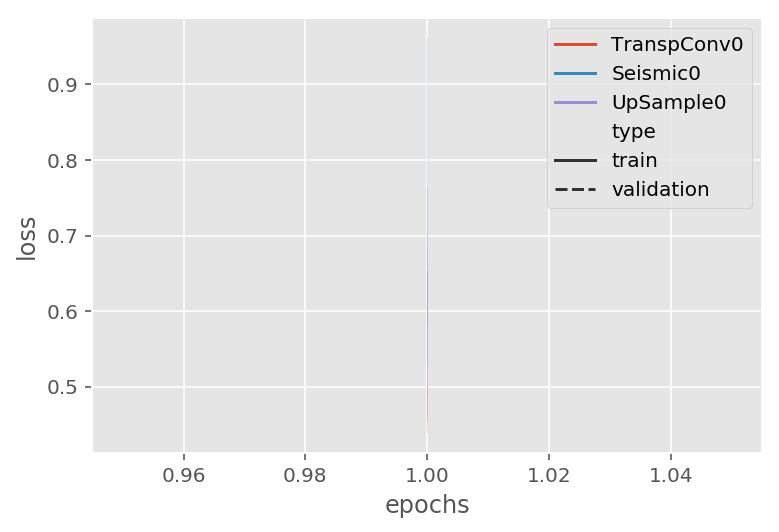

In [40]:
plotComparisonOfModels(historyLists, model_dicts)

In [ ]:
def best_model_more_detailed():
    epochs = 1
    model_name = ["TranspConv", "UpSample"]

    load_model = [get_transp_conv_unet, get_up_sample_unet]

    dropouts = [0.05,0.1]
    model_dicts = []
    for dropout in dropouts:
        for model_idx in range(len(model_name)):
            arg = {}
            arg['dropout'] = dropout
            arg['input_img'] = Input((32,32,1))
            model_dict = {}
            model_dict['load_model'] = load_model[model_idx]
            model_dict['args'] = arg
            model_dict['name'] = model_name[model_idx] + str(dropout)
            model_dicts.append(model_dict)
    models = []
    historyLists =[]
    for model_dict in model_dicts:
        print(model_dict['name'])
        model, historyList = train(epochs = epochs, n_folds = 2, model_dict = model_dict)
        models.append(model)
        historyLists.append(historyList)
    return historyLists, model_dicts, models

In [44]:
historyLists_detail, model_dicts_detail, models_detail = best_model_more_detailed()

TranspConv0.05
Epoch 1/1
46/46 [==============================] - 42s 910ms/step - loss: 0.4921 - val_loss: 0.4640
Epoch 1/1
46/46 [==============================] - 41s 890ms/step - loss: 0.5269 - val_loss: 0.4746
Epoch 1/1
46/46 [==============================] - 41s 893ms/step - loss: 0.5234 - val_loss: 0.4315
Epoch 1/1
46/46 [==============================] - 41s 902ms/step - loss: 0.5269 - val_loss: 0.5005
UpSample0.05
Epoch 1/1
46/46 [==============================] - 40s 866ms/step - loss: 0.4483 - val_loss: 0.7886
Epoch 1/1
46/46 [==============================] - 72s 2s/step - loss: 0.4594 - val_loss: 0.4265
Epoch 1/1
46/46 [==============================] - 41s 895ms/step - loss: 0.4557 - val_loss: 0.4185
Epoch 1/1
46/46 [==============================] - 42s 904ms/step - loss: 0.4535 - val_loss: 0.4502
TranspConv0.1
Epoch 1/1
46/46 [==============================] - 44s 964ms/step - loss: 0.5101 - val_loss: 1.0707
Epoch 1/1
46/46 [==============================] - 46s 991ms/

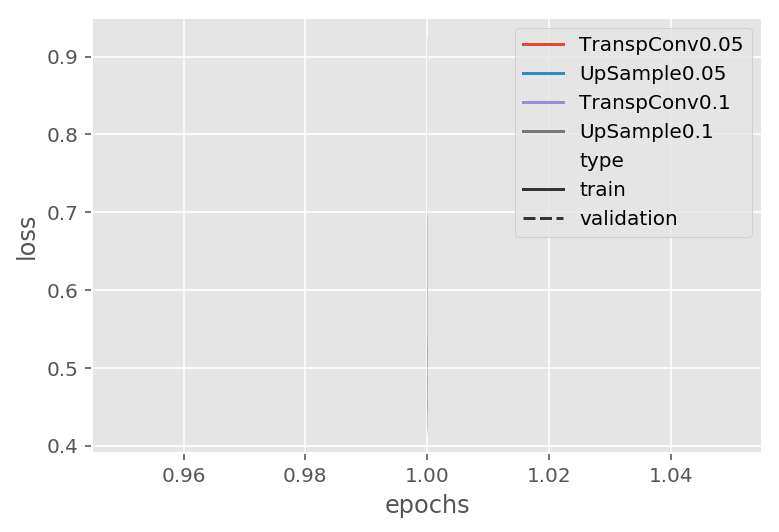

In [45]:
plotComparisonOfModels(historyLists_detail, model_dicts_detail)

In [ ]:
nr_of_images = 10
fig, ax = plt.subplots(nr_of_images,4, figsize=(8,20))
fig.tight_layout()
for image_nr in range(nr_of_images):
    ax[image_nr,0].imshow(X_train[image_nr].reshape(32,32))
    ax[image_nr,1].imshow(y_train[image_nr].reshape(32,32))
    y_pred = res.predict(X_train[image_nr:(image_nr+1)]).reshape(32,32)
    y_pred_thr = y_pred.copy()
    y_pred_thr[y_pred > 0.5] = 1
    y_pred_thr[y_pred <= 0.5] = 0
    ax[image_nr,2].imshow(y_pred)
    ax[image_nr,3].imshow(y_pred_thr)
    for j in range(4):
        ax[image_nr,j].set_xticklabels([])
        ax[image_nr,j].set_yticklabels([])
plt.show()



In [ ]:
drive_test_images = helpers.load_images_from_folder(helpers.DRIVE_TEST_IMAGES_PATH)
drive_test_mask = helpers.load_images_from_folder(helpers.DRIVE_TEST_MASK_PATH)
drive_test_segmented = helpers.load_images_from_folder(helpers.DRIVE_TEST_SEG_1_PATH)

drive_training_images = helpers.load_images_from_folder(helpers.DRIVE_TRAINING_IMAGES_PATH)
drive_training_mask = helpers.load_images_from_folder(helpers.DRIVE_TRAINING_MASK_PATH)
drive_training_segmented = helpers.load_images_from_folder(helpers.DRIVE_TRAINING_SEG_1_PATH)

In [ ]:
image_segmentation = helpers.segment_image(drive_images[0], drive_mask[0], res, 32, helpers.Dataset.DRIVE)
full_image_segmentation = helpers.segment_whole_image(drive_images[0], drive_mask[0], 32, helpers.Dataset.DRIVE, res)
fig, ax = plt.subplots(1,4, figsize=(20,20))
ax[0].imshow(full_image_segmentation)
ax[1].imshow(image_segmentation)
ax[2].imshow(drive_segmented[0])
ax[3].imshow(helpers.histogram_equalization(drive_images[0]))

plt.show()

In [ ]:
def get_test_score(images, mask, segmentation, model, plot=False):
    total_auc_score = 0
    if plot:
        fig, ax = plt.subplots(len(images),3, figsize=(20,20))
    for (i, image) in enumerate(images):
        full_image_segmentation = helpers.segment_whole_image(image, mask[i], 32, helpers.Dataset.DRIVE, res)
        auc_score = helpers.roc_auc(full_image_segmentation, segmentation[i], mask[i])
        total_auc_score += auc_score
        if plot:
            ax[i, 0].imshow(full_image_segmentation)
            ax[i, 1].imshow(segmentation[i])
            ax[i, 2].imshow(image)
            
    print('Average auc score: ', total_auc_score/ len(images) )
    if plot:
        plt.show()
            